# Iris

## Data


In [1]:
import theano
import theano.tensor as T
import numpy as np
from sklearn.datasets import load_iris
from theano.sandbox import cuda


theano.config.floatX = 'float32'
cuda.use('gpu')
theano.config.compute_test_value = 'off'

iris = load_iris()
n_classes = len(iris.target_names)

data_input    = np.asarray(iris.data, dtype=theano.config.floatX)
data_label    = np.zeros(shape=(len(iris.target), n_classes), dtype=theano.config.floatX)
classes_names = iris.target_names

for i, c in enumerate(iris.target):
    data_label[i, int(c)] = 1.0 


Using gpu device 0: GeForce GT 630M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN not available)


## Training

In [8]:
import sys
import time
sys.path.insert(0, r'../../')

from libML.nnet import MLP
from libML.trainers import TrainerMLP
from sklearn.cross_validation import ShuffleSplit
from utils.ClassifierMetrics import ClassifierMetrics

classifier = MLP(data_input.shape[1], [5], n_classes,
                 output_activation=T.tanh,
                 hidden_activation=[T.tanh], type_output="classifier")

trainerMLP = TrainerMLP(classifier, cost="MSE", lr_adapt="CONS",
                        initial_learning_rate=0.05, initial_momentum_rate=0.9, regularizer="L2+L1")

folds = 5
sss = ShuffleSplit(data_input.shape[0], n_iter=folds, test_size=None, train_size=0.5, random_state=0)
max_epoch = 200
validation_jump = 5

metrics = ClassifierMetrics(classes_names)

train_cost = np.zeros(shape=(max_epoch, folds))
test_cost = np.zeros(shape=(int(max_epoch / validation_jump), folds))

for i, (train_set, test_set) in enumerate(sss):
    # data train and test
    data_train = data_input[train_set]
    data_test = data_input[test_set]
    label_train = data_label[train_set]
    label_test = data_label[test_set]

    # training
    tic = time.time()
    train_cost[:, i], test_cost[:, i], best_iteration, best_test_cost, best_test_output = \
        trainerMLP.trainer(data_train, label_train, data_test, label_test,
                           max_epoch=max_epoch, reg_L1=1e-2, reg_L2=1e-3, batch_size=32,
                           validation_jump=validation_jump, early_stop_th=4)
    toc = time.time()

    # Reset parameters and compute metrics
    classifier.reset()
    metrics.append(classes_names[T.argmax(data_label[test_set], axis=1).eval()], classes_names[best_test_output])
    print("%d Elapsed time [s]: %f" % (i, toc - tic))
print("FINISHED!")

0 Elapsed time [s]: 0.493615
1 Elapsed time [s]: 0.545590
2 Elapsed time [s]: 0.501940
3 Elapsed time [s]: 0.522358
4 Elapsed time [s]: 0.554844
FINISHED!


## Results

[[ 24.4   0.    0. ]
 [  0.   14.   10.4]
 [  0.    0.   26.2]]
Results:
Precision:	 1.000000 +- 0.000000
Recall:		 1.000000 +- 0.000000
FPR:		 0.000000 +- 0.000000
FoM:		 1.000000 +- 0.000000


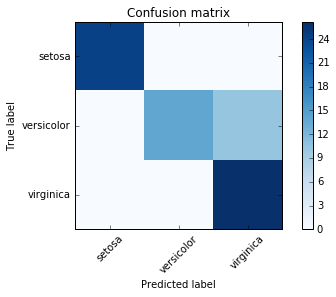

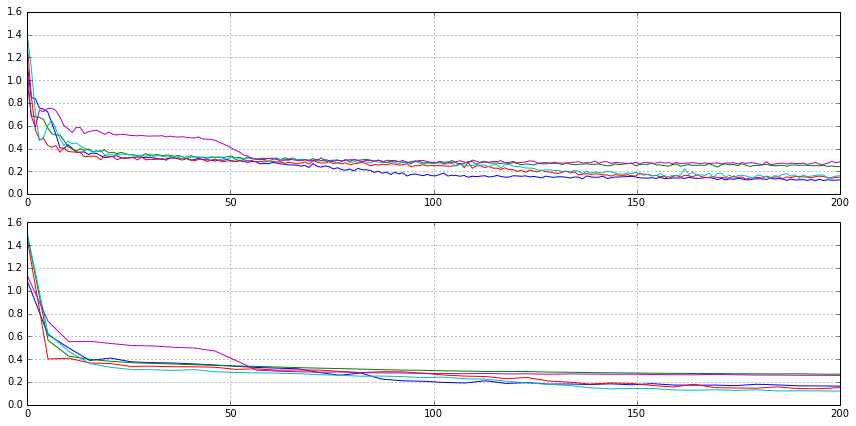

In [9]:
%matplotlib inline
import matplotlib.pylab as plt

metrics.print()
metrics.plot_confusion_matrix()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.linspace(0.0, max_epoch, num=max_epoch), train_cost)
# ax.set_xscale('log')
plt.grid()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.linspace(0.0, max_epoch, num=len(test_cost)), test_cost)
# ax.set_xscale('log')
plt.grid()

plt.tight_layout()